In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame
from samplers import MCMC_sampler,Generate_train,ULA
from baselines import set_function
from martingale import approx_q,test_traj

In [2]:
N_burn = 1*10**4 # Burn in period
N_train = 1*10**4 # Number of samples on which we optimize
N_test = 1*10**4 # Number of samples
step = 0.2 # Step size
n_traj_train = 1
n_traj_test = 20 # Number of independent MCMC trajectories for test
f_type = "sum"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 10 #maximal lag order

Choose sampler type (currently only ULA is maintained)

In [3]:
d = 2
mu = 0.5*np.array([1.0,1.0],dtype = float)
#mu_1 = np.array([-1.0])
#mu_2 = np.array([1.0])
#Sigma_1 = np.array([[1.0]])
#Sigma_2 = np.array([[1.0]])
#Sigma = GenerateSigma(d,rand_seed = 777,eps = 0.1) #covariation matrix 
p = 0.5
#Cur_pot = GausMixtureSame(Sigma,mu,p)
#Cur_pot = GaussMixture(Sigma_1,Sigma_2,mu_1,mu_2,p)
Cur_pot = GausMixtureIdent(mu,p)
r_seed = 777

Generate data

In [4]:
traj = ULA(r_seed,Cur_pot,step, N_burn, N_train, d, return_noise = False)
print(traj.shape)
traj = np.expand_dims(traj, axis=0)
print(traj.shape)

(10000, 2)
(1, 10000, 2)


In [5]:
inds_arr = np.array([0]) # Taking the second index (not intercept)
params = None    
f_vals = set_function(f_type,traj,inds_arr,params)
print(f_vals.shape)

(1, 10000, 1)


Optimize coefficients by solving regression with polynomial features

In [6]:
#polynomial coefficients
coefs_poly = approx_q(traj,f_vals,n_traj_train,lag,S_max)
print(coefs_poly.shape)

dimension =  10000
(10, 6)


Test our regressors

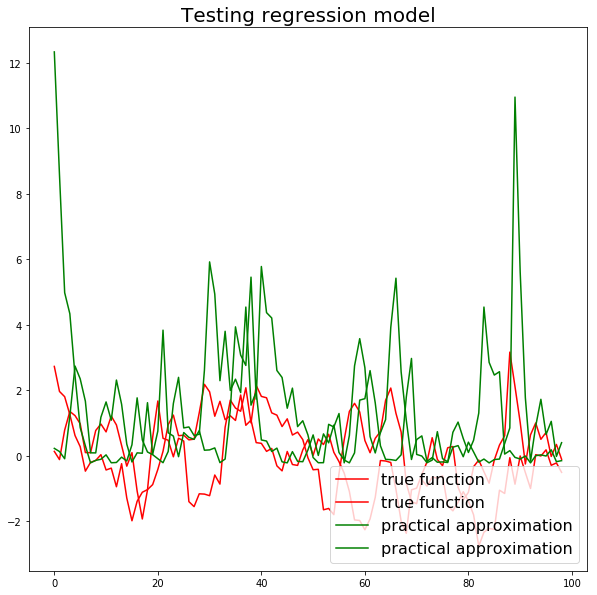

In [7]:
cur_lag = 1
N_pts = 100
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(traj[0,cur_lag:N_pts],color='r',label='true function')
plt.plot(P.polynomial.polyval(traj[0,:N_pts-cur_lag],coefs_poly[cur_lag,:]),color='g',label = 'practical approximation')
#plt.plot(P.polynomial.polyval(X_train[0,:N_pts-cur_lag],coefs_poly_theor[cur_lag,:]),color='b',label = 'theoretical approximation')
plt.legend(loc = 'lower right',fontsize = 16)
plt.show()

In [ ]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d) for i in range (n_traj_test)])
trav.close()

In [ ]:
for ind in range(N_traj):
    np.random.seed(1453 + ind)
    x0 = np.random.randn()
    x_cur = x0
    #burn-in
    for i in range(N_burn):
        x_cur = x_cur - gamma*f_grad(x_cur) + np.sqrt(2*gamma)*np.random.randn()
    #training sample
    #x_cur = X_last
    for i in range(N_test):
        Noise[i] = np.random.randn()
        x_cur = x_cur - gamma*f_grad(x_cur) + np.sqrt(2*gamma)*Noise[i]
        X_test[i] = x_cur
    #compute polynomials at Z_l
    poly_vals = np.zeros((max_deg+1,N_test),dtype = float)
    for k in range(max_deg+1):
        c = np.zeros(max_deg+1)
        c[k] = 1
        poly_vals[k,:] = P.hermite_e.hermeval(Noise,c)/np.sqrt(sp.special.factorial(k))
    f_vals_vanilla = set_func(X_test)
    cvfs = np.zeros_like(f_vals_vanilla)
    for i in range(1,len(cvfs)):
        #start computing a_{p-l} coefficients
        num_poly = min(lag,i)
        a_vals = np.zeros((num_poly,max_deg+1),dtype = float)
        for npol in range(num_poly):#for a fixed lag Q function
            #compute \hat{a} with fixed lag
            x = X_test[i-1-npol]#should be -2 here?
            a_cur = np.zeros(max_deg+1,dtype=float)
            for m in range(len(coefs_poly[0])):
                poly_vspom = np.zeros(max_deg+1,dtype=float)
                for u in range(m+1):
                    poly_vspom[u] = ((x-gamma*f_grad(x))**(m-u))*((np.sqrt(2*gamma))**u)*sp.special.binom(m,u)
                #print(poly_vspom)
                a_cur = P.polynomial.polyadd(a_cur,coefs_poly[npol,m]*poly_vspom)
            #print("a_cur")
            #print(a_cur)
            for k in range(1,max_deg+1):
                c = np.zeros(max_deg+1)
                c[k] = 1
                herm_coef = P.hermite_e.herme2poly(c)
                #normalize now
                herm_coef = herm_coef / np.sqrt(sp.special.factorial(k))
                integr_coefs = P.polynomial.polymul(herm_coef,a_cur)
                #Note that a_vals are stored in reversed order
                a_vals[-(npol+1),k] = np.dot(integr_coefs,moments_stand_norm[:len(integr_coefs)])
            #OK, now I have coefficients of the polynomial, and I need to integrate it w.r.t. Gaussian measure
        #print(a_vals.shape)
        #print(a_vals)
        cvfs[i] = np.sum(a_vals*(poly_vals[:,i-num_poly+1:i+1].T))
        #cvfs[i] = np.sum(np.mean(a_vals,axis = 0))
        if (i%100 == 0):
            print("100 observations proceeded")
        #save results
        test_stat_vanilla[ind,i] = np.mean(f_vals_vanilla[1:(i+1)])
        test_stat_vr[ind,i] = test_stat_vanilla[ind,i] - np.sum(cvfs[:i])/i

In [ ]:
print(test_stat_vanilla[1,N_min:N_min+100])
print(test_stat_vr[1,N_min:N_min+100])
print(test_stat_vanilla[1,-1])
print(test_stat_vr[1,-1])

In [ ]:
vars_vanilla = np.var(test_stat_vanilla,axis = 0)
vars_adj = np.var(test_stat_vr,axis = 0)
print(vars_vanilla[N_min:N_min+10])
print(vars_adj[N_min:N_min+10])
print(np.mean(vars_adj[N_min:]/vars_vanilla[N_min:]))

In [ ]:
print(np.mean(vars_adj[-10:]/vars_vanilla[-10:]))